In [0]:
# Education - Udacity "Intro to TensorFlow for Deep Learning"
# Module: Forecasting with Stateful Recurrent Neural Network
# REF: https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c07_forecasting_with_stateful_rnn.ipynb

In [2]:
# Import packages.
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import matplotlib.pyplot as plt

# Using version 2.x of Tensorflow.
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Tensorflow.
import tensorflow as tf

# Print Tensorflow version.
print('TensorFlow Version:', tf.__version__)

TensorFlow 2.x selected.
TensorFlow Version: 2.1.0


In [0]:
# ====================
# Helper Function
# ====================
# Plot serie.
def plot_series(time, series, format="-", start=0, end=None, label=None):
  plt.plot(time[start:end], series[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Value")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)


# Trend.
def trend(time, slope=0):
  return slope * time


# Seasonal pattern.
def seasonal_pattern(season_time):
  # Just an arbitrary pattern.
  return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi), 1 / np.exp(3 * season_time))


# Seasonality.
def seasonality(time, period, amplitude=1, phase=0):
  # Repeats the same pattern at each period.
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)


# White noise.
def white_noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level


# Simple window dataset.
def window_dataset(series, window_size, batch_size = 32, shuffle_buffer = 1000):
  # Create a dataset of tensors.
  dataset = tf.data.Dataset.from_tensor_slices(series)

  # Drop remaining values so we get same size.
  dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)

  # The dataset contains a tensor with size of 5.
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

  # Split into two arrays, one for inputs and one for labels.
  dataset = dataset.map(lambda window: (window[ : -1], window[-1 : ]))

  # Shuffle the dataset.
  dataset = dataset.shuffle(shuffle_buffer)

  # Create batches. The 'prefetch' indicates the Tensorflow will
  # fetch the data while working, so we always have data to use.
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset


# Sequential window dataset.
def sequential_window_dataset(series, window_size):
  series = tf.expand_dims(series, axis = -1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift = window_size, drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  return ds.batch(1).prefetch(1)


# Sequence to sequence dataset.
def seq2seq_window_dataset(series, window_size, batch_size = 32, shuffle_buffer = 1000):
  series = tf.expand_dims(series, axis = -1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  return ds.batch(batch_size).prefetch(1)


# Predict function.
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast


# Custom callback for reset the state.
class ResetStateCallback(tf.keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs):
    self.model.reset_states()

In [4]:
# Test of creating sqeuantial window dataset.
for X_batch, y_batch in sequential_window_dataset(tf.range(10), 3):
    print(X_batch.numpy(), y_batch.numpy())

[[[0]
  [1]
  [2]]] [[[1]
  [2]
  [3]]]
[[[3]
  [4]
  [5]]] [[[4]
  [5]
  [6]]]
[[[6]
  [7]
  [8]]] [[[7]
  [8]
  [9]]]


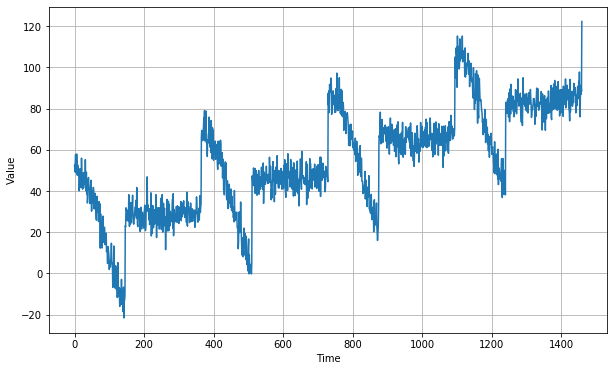

In [5]:
# Create dataset.
time      = np.arange(4 * 365 + 1)
slope     = 0.05
baseline  = 10
amplitude = 40
series    = baseline + trend(time, slope) + seasonality(time, period = 365, amplitude = amplitude)

noise_level = 5
noise       = white_noise(time, noise_level, seed = 42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [0]:
# Prepare for machine learning.
split_time    = 1000
time_train    = time[:split_time]
series_train  = series[:split_time]
time_valid    = time[split_time:]
series_valid  = series[split_time:]

In [7]:
# ==================
# Stateful RNN Forecasting
# ==================
# Clear session, just useful under development, as we usually
# run the session multiple time in the notebook.
SEED        = 42
WINDOW_SIZE = 30
tf.keras.backend.clear_session()
tf.random.set_seed(SEED)
np.random.seed(SEED)

dataset_train = sequential_window_dataset(series_train, WINDOW_SIZE)

# Build the RNN model.
model = tf.keras.models.Sequential([
  tf.keras.layers.SimpleRNN(100, return_sequences = True, stateful = True, batch_input_shape = [1, None, 1]),
  tf.keras.layers.SimpleRNN(100, return_sequences = True, stateful = True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 30)
)
reset_states = ResetStateCallback()
model.compile(
  loss = tf.keras.losses.Huber(),
  optimizer = tf.keras.optimizers.SGD(lr = 1e-8, momentum = 0.9),
  metrics = ["mae"]
)
history = model.fit(dataset_train, epochs = 100, callbacks = [lr_schedule, reset_states])

Epoch 1/100
33/33 [==============================] - 4s 113ms/step - loss: 105.9340 - mae: 106.4340
Epoch 2/100
33/33 [==============================] - 1s 35ms/step - loss: 70.8572 - mae: 71.3572
Epoch 3/100
33/33 [==============================] - 1s 30ms/step - loss: 39.8080 - mae: 40.3048
Epoch 4/100
33/33 [==============================] - 1s 29ms/step - loss: 27.3450 - mae: 27.8404
Epoch 5/100
33/33 [==============================] - 1s 29ms/step - loss: 24.4956 - mae: 24.9892
Epoch 6/100
33/33 [==============================] - 1s 28ms/step - loss: 23.2601 - mae: 23.7517
Epoch 7/100
33/33 [==============================] - 1s 29ms/step - loss: 22.0604 - mae: 22.5533
Epoch 8/100
33/33 [==============================] - 1s 28ms/step - loss: 20.8543 - mae: 21.3463
Epoch 9/100
33/33 [==============================] - 1s 30ms/step - loss: 19.8307 - mae: 20.3245
Epoch 10/100
33/33 [==============================] - 1s 31ms/step - loss: 18.9399 - mae: 19.4319
Epoch 11/100
33/33 [======

[1e-08, 0.0001, 0, 30]

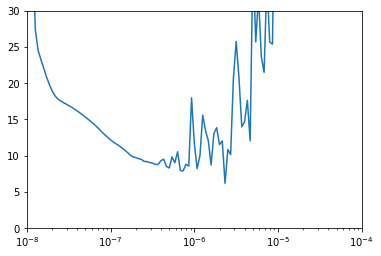

In [8]:
# Find the optimal learning rate.
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [0]:
# As we see that it would be safe to start with 1e-7.

In [10]:
# Update model with the learning rate.
tf.keras.backend.clear_session()
tf.random.set_seed(SEED)
np.random.seed(SEED)

checkpoint_name = "statefil_rnn_checkpoint.h5"
dataset_train   = sequential_window_dataset(series_train, WINDOW_SIZE)
dataset_valid   = sequential_window_dataset(series_valid, WINDOW_SIZE)

model = tf.keras.models.Sequential([
  tf.keras.layers.SimpleRNN(100, return_sequences = True, stateful = True, batch_input_shape = [1, None, 1]),
  tf.keras.layers.SimpleRNN(100, return_sequences = True, stateful = True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200.0)
])

model.compile(
  loss = tf.keras.losses.Huber(),
  optimizer = tf.keras.optimizers.SGD(lr = 1e-7, momentum = 0.9),
  metrics = ["mae"]
)

early_stopping    = tf.keras.callbacks.EarlyStopping(patience = 50)
reset_states      = ResetStateCallback()
model_checkpoint  = tf.keras.callbacks.ModelCheckpoint(checkpoint_name, save_best_only = True)
model.fit(
  dataset_train,
  epochs = 500,
  validation_data = dataset_valid,
  callbacks = [early_stopping, model_checkpoint, reset_states]
)

Epoch 1/500
33/33 [==============================] - 2s 74ms/step - loss: 60.2499 - mae: 60.7478 - val_loss: 25.0217 - val_mae: 25.5179
Epoch 2/500
33/33 [==============================] - 1s 35ms/step - loss: 21.4714 - mae: 21.9618 - val_loss: 10.9142 - val_mae: 11.4074
Epoch 3/500
33/33 [==============================] - 1s 33ms/step - loss: 18.7249 - mae: 19.2167 - val_loss: 12.0569 - val_mae: 12.5479
Epoch 4/500
33/33 [==============================] - 1s 34ms/step - loss: 17.5231 - mae: 18.0143 - val_loss: 10.4489 - val_mae: 10.9391
Epoch 5/500
33/33 [==============================] - 1s 32ms/step - loss: 16.6983 - mae: 17.1891 - val_loss: 9.9581 - val_mae: 10.4499
Epoch 6/500
33/33 [==============================] - 1s 33ms/step - loss: 15.9090 - mae: 16.3984 - val_loss: 9.1539 - val_mae: 9.6415
Epoch 7/500
33/33 [==============================] - 1s 32ms/step - loss: 15.2155 - mae: 15.7027 - val_loss: 8.3393 - val_mae: 8.8249
Epoch 8/500
33/33 [==============================] - 

In [0]:
# Load best model.
model = tf.keras.models.load_model(checkpoint_name)

In [12]:
# Forcast the model.
model.reset_states()
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]
rnn_forecast.shape

(461,)

MAE: 6.2778373


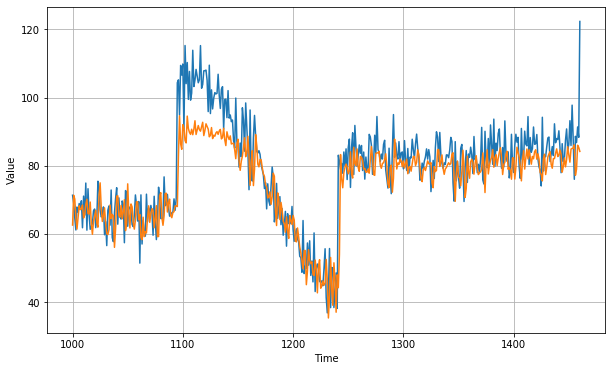

In [13]:
# Plot the forecast.
plt.figure(figsize = (10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

mae = tf.keras.metrics.mean_absolute_error(series_valid, rnn_forecast).numpy()
print("MAE:", mae)